In [1]:
#import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import matplotlib as mpl
import skimage.feature
import skimage.color

#4s

```bash
data/
├── comp3314-delaynomore.ipynb
├── train_ims
├── test_ims
├── train.csv
└── test.csv
```

In [9]:
from tqdm import tqdm

# loading training data
df = pd.read_csv("./train.csv")
image_names = np.array(df.iloc[:,0])
labels = np.array(df.iloc[:,1])
image_paths = "./train_ims/" + image_names
images = []

# Use the tqdm library to wrap the loop and add a progress bar
for path in tqdm(image_paths, desc='Loading images', unit='image'):
    image = cv2.imread(path)
    images.append(image)

print("data loaded")



Loading images: 100%|██████████| 50000/50000 [03:49<00:00, 218.10image/s] 

data loaded


In [ ]:
#loading test images
df_ = pd.read_csv("./test.csv")
image_names_ = np.array(df_.iloc[:,0])

image_paths_ = "./test_ims/" + image_names_

for path in image_paths_:
    image = cv2.imread(path)
    images.append(image)

In [4]:
#astype nparray
images = np.array(images)

In [5]:
images.shape

(60000, 32, 32, 3)

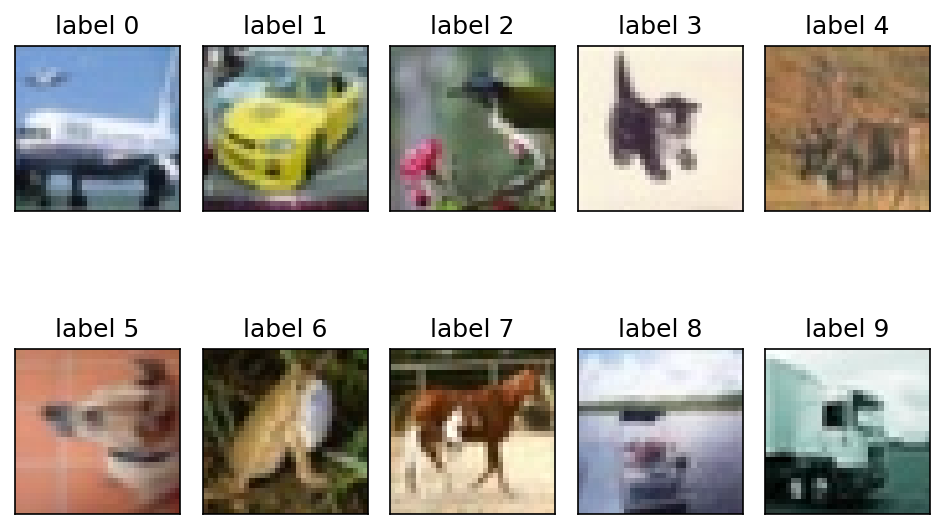

In [6]:
#visualize

def found():
    count = 10
    dic = np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
    for i in range(len(labels)):
        if dic[labels[i]] == -1:
            dic[labels[i]] = i
            count -= 1
        if count == 0:break
    return dic
def show_images(xs,dimx=32,dimy=32,channel=3):
    mpl.rcParams["figure.dpi"] = 150
    num_rows = 2
    num_cols = 5
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True)
    ax = ax.flatten()
    dic = found()
    xs_show = xs.reshape(60000,dimx,dimy,channel)
    for index in range(num_rows * num_cols):
        img = xs_show[dic[index]]
        label = labels[dic[index]]
        ax[index].imshow(img, cmap="Greys", interpolation="nearest")
        ax[index].set_title("label " + str(label))

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
show_images(images)

In [7]:
#statistic of the number of each class
for i in range(10):
    number = np.count_nonzero(labels == i)
    print(f"The number of images with label {i} is: ",number)

The number of images with label 0 is:  5038
The number of images with label 1 is:  5016
The number of images with label 2 is:  5032
The number of images with label 3 is:  4991
The number of images with label 4 is:  4982
The number of images with label 5 is:  4967
The number of images with label 6 is:  4985
The number of images with label 7 is:  4998
The number of images with label 8 is:  5002
The number of images with label 9 is:  4989


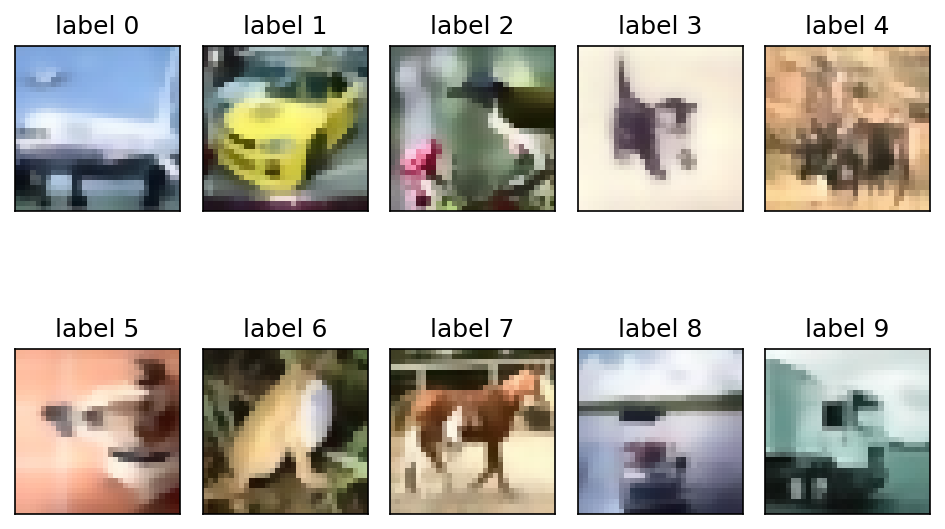

In [8]:
#enhence & normalization
def basic_preprocessing(images):
    processed = images.astype(np.float32) / 255.0
    processed_batch = np.zeros_like(processed)
    
    for i in range(images.shape[0]):
        img = images[i]
        
        # Contrast Enhancement
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
        lab[:, :, 0] = clahe.apply(lab[:, :, 0])  # Only L is processed
        enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        # Edge-preserving filter
        filtered = cv2.bilateralFilter(enhanced, d=5, sigmaColor=75, sigmaSpace=75)
        
        processed_batch[i] = filtered
    
    return processed_batch


images_train_processed = basic_preprocessing(images)

images_train_processed = images_train_processed.astype(int)
show_images(images_train_processed)
#running time: 20s

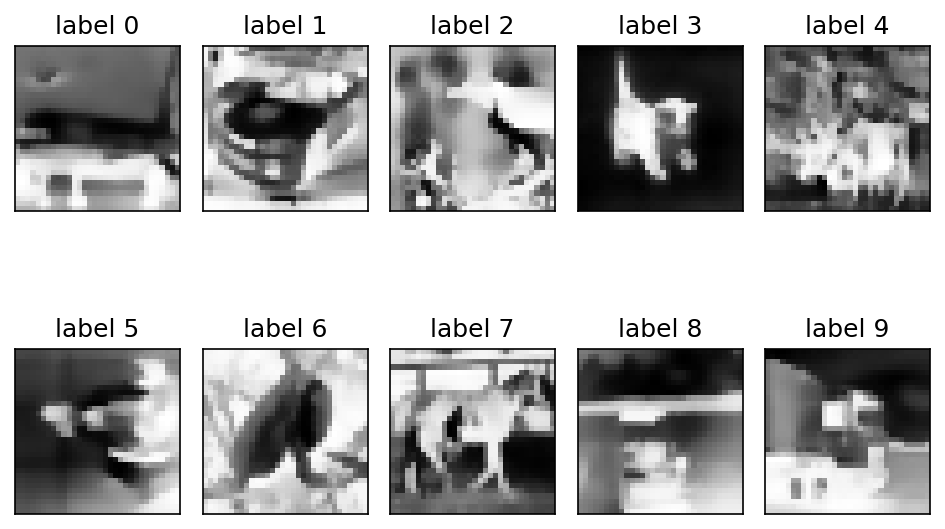

In [9]:
#rgb2gray
def rgb2gray(images):
    return np.dot(images[...,:3],[0.299, 0.587, 0.114])
images_gray = rgb2gray(images_train_processed)
show_images(images_gray,32,32,1)


In [10]:
#HOG & LBP features extract
from skimage.feature import hog,local_binary_pattern


def HOG(image):
    image_hog = hog(image=image,visualize=False, cells_per_block=(2,2),pixels_per_cell=(8,8),orientations=9)
    return image_hog
def LBP(img):
    img_blur = cv2.GaussianBlur(img, (3,3), 0)
    lbp_features = []
    gray = cv2.cvtColor(img_blur, cv2.COLOR_RGB2GRAY)
    for R, P in zip([1,2,3], [8, 16, 24]):
        lbp = local_binary_pattern(gray, P=P, R=R, method='uniform')
        hist = np.histogram(lbp, bins=P+2, range=(0, P+2))[0]
        lbp_features.extend(hist / hist.sum())  # Normalization
    return lbp_features
def HOG_batch(images):
    images_HOG = np.zeros((len(images), 324), dtype=np.float32)
    for i in range(len(images)):
        this_image = images[i]
        images_HOG[i] = HOG(this_image)
    return images_HOG
def LBP_batch(images):
    lbp_features = []
    for img in images:
        lbp_features.append(LBP(img))
    return np.array(lbp_features)
# images_HOG = HOG_batch(images_gray)
# images_LBP = LBP_batch(images_gray.astype(int)) #=>can not extract feature
#running time: 18s

In [11]:
#HSV features extract
from skimage.color import rgb2hsv
images_HSV = rgb2hsv(images_train_processed)
#running time 30s

/usr/local/lib/python3.11/dist-packages/skimage/color/colorconv.py:322: RuntimeWarning: divide by zero encountered in divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/usr/local/lib/python3.11/dist-packages/skimage/color/colorconv.py:326: RuntimeWarning: divide by zero encountered in divide
  out[idx, 0] = 2.0 + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/usr/local/lib/python3.11/dist-packages/skimage/color/colorconv.py:330: RuntimeWarning: divide by zero encountered in divide
  out[idx, 0] = 4.0 + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


In [12]:
# SIFT features extraction
import cv2
import numpy as np


def SIFT(img, nfeature):
    # Convert RGB image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Create SIFT detector with specified maximum number of features
    sift = cv2.SIFT_create(nfeatures=nfeature)
    
    # Detect keypoints and compute descriptors
    # kp: Keypoint information (includes orientation, scale, position)
    # des: Feature descriptors (128-dimensional vector for each keypoint)
    kp, des = sift.detectAndCompute(gray_img, None)
    
    return des


def SIFT_batch(images, nfeature):
    """Batch processing for SIFT feature extraction
    
    Parameters:
    images (list): List of input images (RGB format, uint8 array)
    nfeature (int): Maximum number of features to retain per image
    
    Returns:
    list: List of feature descriptors for each image
    """
    descriptors = []
    for i in range(len(images)):
        # Process each image and convert to uint8 (required by OpenCV)
        des = SIFT(images[i].astype(np.uint8), nfeature)
        
        # Handle cases where no keypoints are detected (return zero-filled array)
        if des is not None:
            # Truncate to keep only the top 'nfeature' descriptors
            descriptors.append(des[:nfeature, :])
        else:
            # Fallback to zero vector with expected shape (nfeature x 128)
            descriptors.append(np.zeros((nfeature, 128)))
    
    return descriptors

# Example usage:
# images_SIFT_descriptors_raw = SIFT_batch(images_train_processed, 10)
# Running time: Approximately 1 minute for batch processing

In [13]:
def pad(arrays, dim):
    # Find the maximum number of rows (max x value)
    max_rows = max(arr.shape[0] for arr in arrays)

    # Create a padded array with shape (len(arrays), max_rows, dim)
    padded_array = np.zeros((len(arrays), max_rows, dim))

    for i, arr in enumerate(arrays):
        # Fill the current array's contents into the padded array
        padded_array[i, :arr.shape[0], :] = arr

    # Return the array with shape (50000, max_rows, dim)
    return padded_array.transpose(0, 1, 2)  # Adjust order if needed

# Example usage
# images_SIFT_descriptors_padded = pad(images_SIFT_descriptors_raw, 128)

In [14]:
import os
import pickle
import cv2
import numpy as np

def FAST(train_data):
    # Function to detect features using different algorithms
    def detect_features(image, method='FAST'):
        # Ensure the image is in uint8 format
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
        
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        if method == 'FAST':
            # Create FAST detector
            fast = cv2.FastFeatureDetector_create(threshold=10)
            keypoints = fast.detect(gray, None)
        else:
            raise ValueError("Unsupported method")
        
        return keypoints

    # Iterate through the training set and detect feature points
    fast_keypoints_list = []  # Store FAST keypoints for all images

    for i in range(len(train_data)):
        image = train_data[i]
        # Ensure the image is in uint8 format
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
        
        # Detect FAST keypoints
        keypoints = detect_features(image, method='FAST')
        
        # Skip if no keypoints are detected
        if len(keypoints) == 0:
            print(f"Image {i} (Train): No keypoints detected")
            fast_keypoints_list.append(np.array([]))  # Store empty array
            continue
        
        # Convert keypoints to numpy array
        keypoints_array = np.array([(kp.pt[0], kp.pt[1], kp.size, kp.response) for kp in keypoints])
        fast_keypoints_list.append(keypoints_array)
        
        # Optional: Visualize detected keypoints
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # image_with_keypoints = cv2.drawKeypoints(image_bgr, keypoints, None, color=(0, 255, 0))
        # cv2.imshow(f"Keypoints using FAST", image_with_keypoints)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

    # Convert FAST keypoints list to numpy array
    fast_keypoints_array = np.array(fast_keypoints_list, dtype=object)

    return fast_keypoints_array

In [15]:
#daisy features extract
import cv2
import numpy as np

def DAISY(images):
    daisy_features = []
    # Create DAISY descriptor and set parameters
    descriptor = cv2.xfeatures2d.DAISY_create()
    for img in images:
        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Compute DAISY features
        # Create evenly distributed keypoints
        keypoints = [cv2.KeyPoint(x, y, 10) for x in range(0, gray.shape[1], 10) for y in range(0, gray.shape[0], 10)]
        _, daisy_descriptors = descriptor.compute(gray, keypoints)  # Get descriptors
        # Flatten the descriptors and add to the feature list
        daisy_features.append(daisy_descriptors.flatten())
    return np.array(daisy_features)

In [16]:
#generate features
images_processed = basic_preprocessing(images)
images_gray = rgb2gray(images_processed)
images_HOG = HOG_batch(images_gray)
images_HSV = rgb2hsv(images_processed)
images_FAST = pad(FAST(images_processed),4)
image_SIFT = pad(SIFT_batch(images_processed,3),128)
images_initiated = (images,images_processed,images_gray,images_HOG,images_HSV,image_SIFT,images_FAST)
images_lbp = LBP_batch(images_processed.astype(np.uint8))

In [17]:
images_daisy = DAISY(images_processed)

In [18]:
#pca for each single feature
from sklearn.decomposition import PCA
def doPCA(X,percentage = 0.95):
    pca = PCA(n_components=percentage)
    X_pca = pca.fit_transform(X)
    return X_pca

In [19]:
#normalize & pca for each feature
from sklearn.preprocessing import StandardScaler, MinMaxScaler
"""hog+hsv+sift combined features"""
# images for different feature generating techniques
img_gray = images_initiated[2]
img_hog = images_initiated[3]
img_hsv = images_initiated[4]
img_sift = images_initiated[5]
img_fast = images_initiated[6]
img_lbp = images_lbp
img_daisy = images_daisy
# flatten those features respectively
X_hog = np.array([img.flatten() for img in img_hog])
X_hsv = np.array([img.flatten() for img in img_hsv])
X_sift = np.array([img.flatten() for img in img_sift])
X_gray = np.array([img.flatten() for img in img_gray])
X_fast = np.array([img.flatten() for img in img_fast])
X_lbp = np.array([img.flatten() for img in img_lbp])
X_daisy = np.array([img.flatten() for img in img_daisy])
# scaling respectively
scaler = StandardScaler()
X_hog_scaled = scaler.fit_transform(X_hog)
X_hsv_scaled = scaler.fit_transform(X_hsv)
X_sift_scaled = scaler.fit_transform(X_sift)
X_gray_scaled = scaler.fit_transform(X_gray)
X_fast_scaled = scaler.fit_transform(X_fast)
X_lbp_scaled = scaler.fit_transform(X_lbp)
X_daisy_scaled =scaler.fit_transform(X_daisy)





X_hog_scaled_pca = doPCA(X_hog_scaled,0.99)
X_hsv_scaled_pca = doPCA(X_hsv_scaled)
X_sift_scaled_pca = doPCA(X_sift_scaled)
X_gray_scaled_pca = doPCA(X_gray_scaled)
X_fast_scaled_pca = doPCA(X_fast_scaled)


X_lbp_scaled_pca = doPCA(X_lbp_scaled)
X_daisy_scaled_pca = doPCA(X_daisy_scaled)

In [20]:
#conbine selected feature into a single array
X_combined = np.hstack([X_hog_scaled_pca*2.5, X_hsv_scaled_pca, X_fast_scaled_pca*0.5, X_daisy_scaled_pca*1.5,X_lbp_scaled_pca*1.2])
"""
combinations:
[hog,hsv,fast,daisy]=[2.5,1,0.5,1.5] --> traintestsplit acc: 0.7198, unlabeled test acc: 0.7205
[hog,hsv,fast,daisy,lbp]=[2.5,1,0.5,1.5,1.2] --> unlabeled test acc: 0.7220
[hog,hsv,daisy,lbp]=[2.5,1,1.5,1.2] --> traintestsplit acc: 0.7098, unlabeled test acc: 0.7180

"""

'\ncombinations:\n[hog,hsv,fast,daisy]=[2.5,1,0.5,1.5] --> traintestsplit acc: 0.7198, unlabeled test acc: 0.7205\n[hog,hsv,fast,daisy,lbp]=[2.5,1,0.5,1.5,1.2] --> unlabeled test acc: 0.7220\n[hog,hsv,daisy,lbp]=[2.5,1,1.5,1.2] --> traintestsplit acc: 0.7098, unlabeled test acc: 0.7180\n\n'

In [21]:
def SVM_result(a, b, c, d, e):
    X_combined = np.hstack([X_hog_scaled_pca * a, X_hsv_scaled_pca * b, X_fast_scaled_pca * c, X_daisy_scaled_pca * d, X_lbp_scaled_pca * e])
    
    '''Train-test split'''
    from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X_combined[:50000], y[:50000], test_size=0.2, random_state=42)
    
    """PCA implementation"""
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    import gc
    gc.collect()  # Garbage collection to free memory
    
    """SVM model"""
    from cuml.svm import SVC  
    from sklearn.metrics import accuracy_score, classification_report
    
    # Ensure data is float32 and contiguous for GPU compatibility
    X_train_pca = np.ascontiguousarray(X_train_pca.astype(np.float32))
    X_test_pca = np.ascontiguousarray(X_test_pca.astype(np.float32))
    
    # Manually specify hyperparameters for SVM
    svm = SVC(C=100, gamma='scale', kernel='rbf', cache_size=100, verbose=False)
    
    # Train SVM model on the PCA-transformed training data
    svm.fit(X_train_pca, y_train)
    
    # Make predictions on the test set
    svm_y_pred = svm.predict(X_test_pca)
    
    # Calculate accuracy score between true labels and predictions
    svm_result = accuracy_score(y_test, svm_y_pred)
    print(f"SVM accuracy: {svm_result}")
    
    # Generate classification report for detailed performance metrics
    class_names = np.unique(y_test)  # Assume labels are numpy array
    report = classification_report(y_test, svm_y_pred, target_names=[f"Class {c}" for c in class_names])
    print(f"Accuracy with params {a}, {b}, {c}, {d}, {e}: {svm_result}")  # Print accuracy with current parameters
    
    # Return the accuracy score as the objective value
    return svm_result
#SVM_result(2.09005499, 0.93312492, 0.84358313, 1.12385984, 1.77557874)

In [23]:
'''Train test split'''
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
y = labels
X_train, X_test, y_train, y_test = train_test_split(X_combined[:50000], y[:50000], test_size = 0.2, random_state = 42)

In [24]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [25]:
"""SVM model"""
from cuml.svm import SVC  
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

# Ensure that the data is of type float32 and is contiguous
X_train_pca = np.ascontiguousarray(X_train_pca.astype(np.float32))
X_test_pca = np.ascontiguousarray(X_test_pca.astype(np.float32))


svm = SVC(cache_size = 100,verbose = True)
X_train_pca = X_train_pca.astype(np.float32)
param_grid = {
    'C':[100],
    'gamma': ['scale'],
    'kernel': ['rbf']
}
from sklearn.model_selection import RandomizedSearchCV
# Set the number of parallel threads
search = RandomizedSearchCV(estimator=svm, param_distributions=param_grid, 
                            n_iter=1, cv= 2,n_jobs=2,verbose = 20)
search.fit(X_train_pca, y_train)
best_svm = search.best_estimator_


svm_y_pred = best_svm.predict(X_test_pca)

svm_result = accuracy_score(y_test, svm_y_pred)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START C=100, gamma=scale, kernel=rbf..............................
[2025-04-20 04:49:43.617] [CUML] [debug] Creating working set with 1024 elements
[2025-04-20 04:49:44.187] [CUML] [debug] SMO solver finished after 13 outer iterations, total inner 4902 iterations, and diff 0.000981
[2025-04-20 04:49:44.314] [CUML] [debug] Creating working set with 1024 elements
[2025-04-20 04:49:44.512] [CUML] [debug] SMO solver finished after 21 outer iterations, total inner 8974 iterations, and diff 0.000998
[2025-04-20 04:49:44.533] [CUML] [debug] Creating working set with 1024 elements
[2025-04-20 04:49:44.633] [CUML] [debug] SMO solver finished after 13 outer iterations, total inner 5160 iterations, and diff 0.000969
[2025-04-20 04:49:44.653] [CUML] [debug] Creating working set with 1024 elements
[2025-04-20 04:49:44.767] [CUML] [debug] SMO solver finished after 15 outer iterations, total inner 5907 iterations, and diff 0.000

In [26]:
svm_result


0.7124

In [27]:
search.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'C': 100}

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMClassifier

X_train_pca = np.ascontiguousarray(X_train_pca.astype(np.float32))
X_test_pca = np.ascontiguousarray(X_test_pca.astype(np.float32))

lgbm = LGBMClassifier(
    n_estimators=3000,         # Number of boosting rounds
    max_depth=30,              # Maximum tree depth
    learning_rate=0.003,       # Learning rate
    num_leaves=50,             # Maximum number of leaves in a tree
    min_child_samples=5,      # Minimum number of data needed in a leaf
    subsample=0.6,             # Subsample ratio of the training instance
    colsample_bytree=0.6,      # Subsample ratio of columns when constructing each tree
    device='gpu',              # Enable GPU acceleration
    random_state=42,
    lambda_l1=0.2,              # L1 regularization term on weights
    lambda_l2=0.2,              # L2 regularization term on weights
)

# Train the model
lgbm.fit(X_train_pca, y_train)

# Make predictions on the test set
lgbm_y_pred = lgbm.predict(X_test_pca)

# Calculate accuracy score
lgbm_result = accuracy_score(y_test, lgbm_y_pred)
print("LightGBM Accuracy:", lgbm_result)

[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 78285
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 307
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 307 dense feature groups (11.75 MB) transferred to GPU in 0.012166 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -2.295858
[LightGBM] [Info] Start training from score -2.311374
[LightGBM] [Info] Start training from score -2.290904
[LightGBM] [Info] Start training from score -2.300587
[LightGBM] [Info] Start training from score -2.299091
[LightGBM] [Info] Start training from score -2.304587
[LightGBM] [Info] Start training from score -2.311878
[LightGBM] [Info] Start training from score -2.299839
[LightGBM] [Info] Start training from score -2.301086
[LightGBM] [Info] Start training from score -2.310869
[2025-04-20 04:49:50.080] [CUML] [debug] Creating working set with 1024 elements
[2025-04-20 04:49:50.158] [CUML] [debug] SMO solver finished after 11 outer iterations, total inner 3861 iterations, and diff 0.000993
[2025-04-20 04:49:50.174] [CUML] 

In [29]:
lgbm_result

0.6198

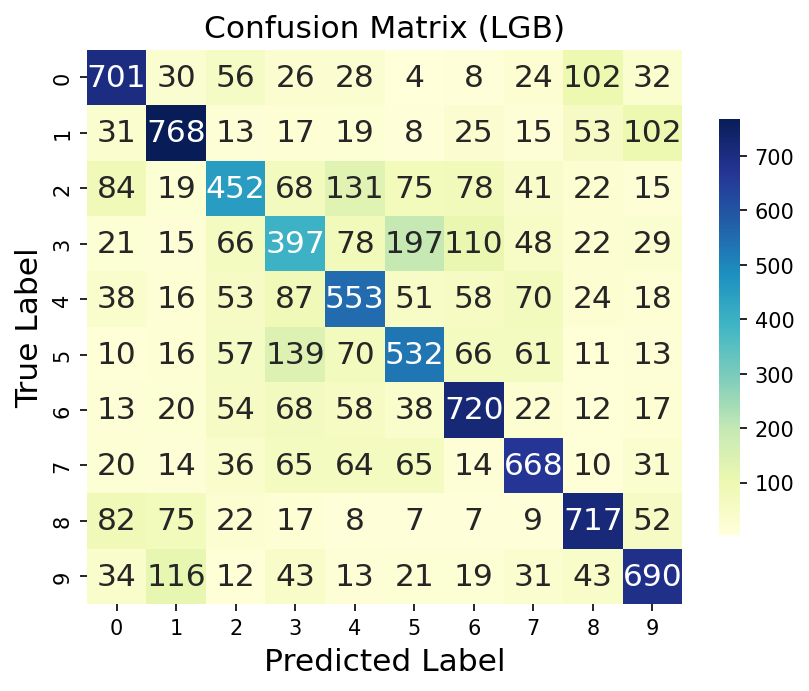

In [30]:
#confusion matrix for LGB
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, lgbm_y_pred)

sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 15}, fmt='d', cmap='YlGnBu', cbar_kws={'shrink': 0.75})
plt.title('Confusion Matrix (LGB)', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

plt.show()

precision_logis = np.diag(conf_matrix) / conf_matrix.sum(axis=0)

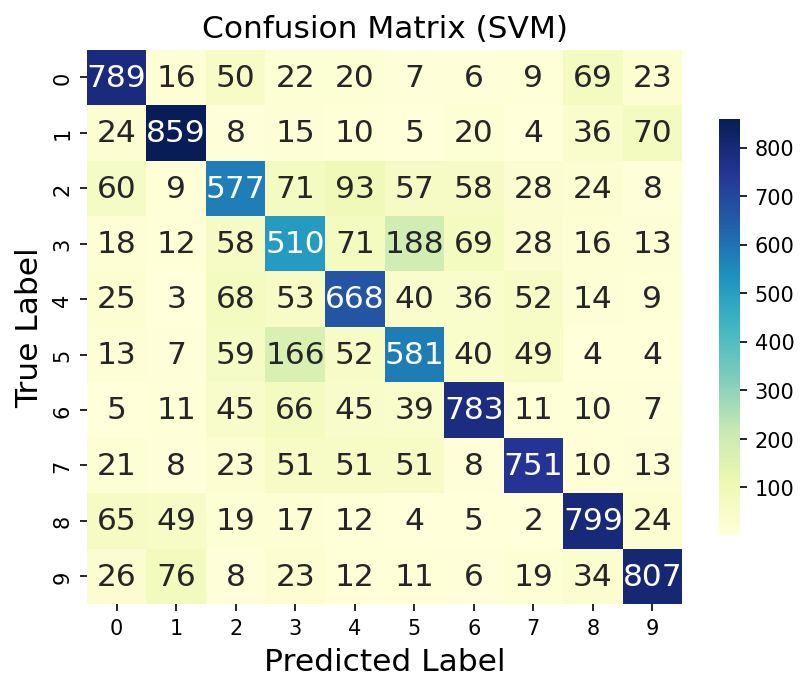

In [31]:
#confusion model for SVM
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, svm_y_pred)

sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 15}, fmt='d', cmap='YlGnBu', cbar_kws={'shrink': 0.75})
plt.title('Confusion Matrix (SVM)', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

plt.show()

precision_svm = np.diag(conf_matrix) / conf_matrix.sum(axis=0)

In [32]:
#use all dataset and same SVM model to predicct the test dataset
pca2 = PCA(n_components=0.95)
X_train_pca2 = pca2.fit_transform(X_combined[:50000])


In [33]:
"""SVM model"""
from cuml.svm import SVC  
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold

# Ensure that the data is of type float32 and is contiguous
X_train_pca2 = np.ascontiguousarray(X_train_pca2.astype(np.float32))



svm = SVC(cache_size = 100,verbose = True)
X_train_pca2 = X_train_pca2.astype(np.float32)
param_grid = {
    'C':[100],
    'gamma': ['scale'],
    'kernel': ['rbf']
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
from sklearn.model_selection import RandomizedSearchCV
# Set the number of parallel threads
search = RandomizedSearchCV(estimator=svm, param_distributions=param_grid, 
                            n_iter=1, cv=2, n_jobs=2,verbose = 20)
search.fit(X_train_pca2, labels)
best_svm = search.best_estimator_



Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START C=100, gamma=scale, kernel=rbf..............................
[2025-04-20 05:13:07.340] [CUML] [debug] Creating working set with 1024 elements
[2025-04-20 05:13:07.786] [CUML] [debug] SMO solver finished after 16 outer iterations, total inner 6492 iterations, and diff 0.000957
[2025-04-20 05:13:07.813] [CUML] [debug] Creating working set with 1024 elements
[2025-04-20 05:13:08.015] [CUML] [debug] SMO solver finished after 25 outer iterations, total inner 11713 iterations, and diff 0.000986
[2025-04-20 05:13:08.034] [CUML] [debug] Creating working set with 1024 elements
[2025-04-20 05:13:08.153] [CUML] [debug] SMO solver finished after 16 outer iterations, total inner 6672 iterations, and diff 0.000998
[2025-04-20 05:13:08.172] [CUML] [debug] Creating working set with 1024 elements
[2025-04-20 05:13:08.295] [CUML] [debug] SMO solver finished after 18 outer iterations, total inner 7583 iterations, and diff 0.00

In [34]:

X_exam = X_combined[50000:]
X_exam_pca2 = pca2.transform(X_exam)
# X_exam_pca2 = pca.transform(X_exam)
y_pre = best_svm.predict(X_exam_pca2)

In [35]:
y_pre

array([3, 4, 0, ..., 1, 4, 2])

In [7]:
#write the test.csv file
def write(y_pre):
    df = pd.read_csv("./test.csv")
    df["label"] = y_pre
    df.to_csv('./test.csv', index=False)

In [8]:
write(y_pre)

### Submitted csv has 72.15% acc